In [1]:
import os
from tqdm import tqdm
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.applications import resnet50
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Helper Functions

In [2]:
def maxProbability(arr):
    
    array=arr[0]
    max = array[0]
    for i in range(1,3):
        if array[i] > max:
            max = array[i]
    return max

In [3]:
def get_label(index):
    
    if index == 0:
        return 'AD'
    if index == 1:
        return 'CN'
    if index == 2:
        return 'MCI'

In [4]:
def max_of_three_indices(array_label):
    
    max_item = array_label[0]
    max_index = 0
    for i in range(1,len(array_label)):
        if array_label[i] > max_item:
            max_item = array_label[i]
            max_index = i
            
    return max_index,max_item

# Data Path

In [5]:
#File of input, MRI Images
image_path_AD_Axial="../input/skullstrippedthreeviewsseparated/AD Axial"
image_path_AD_Coronal="../input/skullstrippedthreeviewsseparated/AD Coronal"
image_path_AD_Sagittal="../input/skullstrippedthreeviewsseparated/AD Sagittal"
image_path_CN_Axial="../input/skullstrippedthreeviewsseparated/CN Axial"
image_path_CN_Coronal="../input/skullstrippedthreeviewsseparated/CN Coronal"
image_path_CN_Sagittal="../input/skullstrippedthreeviewsseparated/CN Sagittal"
image_path_MCI_Axial="../input/skullstrippedthreeviewsseparated/MCI Axial"
image_path_MCI_Coronal="../input/skullstrippedthreeviewsseparated/MCI Coronal"
image_path_MCI_Sagittal="../input/skullstrippedthreeviewsseparated/MCI Sagittal"

# Append Images with their Correct Labels

In [6]:
def append_image_label(path,image_array,label_array,image_view):
    
    image_size=224
    
    for m in tqdm(os.listdir(path)):
        image=cv2.imread(os.path.join(path,m))
        image=cv2.resize(image,(image_size,image_size))
        image_array.append(image)
        label_array.append(image_view)
    
    return image_array,label_array

In [7]:
image_data_axial=[]
label_data_axial=[]
image_data_coronal=[]
label_data_coronal=[]
image_data_sagittal=[]
label_data_sagittal=[]

image_data_axial, label_data_axial = append_image_label(image_path_AD_Axial,image_data_axial,label_data_axial,'AD') 
image_data_coronal, label_data_coronal = append_image_label(image_path_AD_Coronal,image_data_coronal,label_data_coronal,'AD') 
image_data_sagittal, label_data_sagittal = append_image_label(image_path_AD_Sagittal,image_data_sagittal,label_data_sagittal,'AD') 

image_data_axial, label_data_axial = append_image_label(image_path_CN_Axial,image_data_axial,label_data_axial,'CN') 
image_data_coronal, label_data_coronal = append_image_label(image_path_CN_Coronal,image_data_coronal,label_data_coronal,'CN') 
image_data_sagittal, label_data_sagittal = append_image_label(image_path_CN_Sagittal,image_data_sagittal,label_data_sagittal,'CN')

image_data_axial, label_data_axial = append_image_label(image_path_MCI_Axial,image_data_axial,label_data_axial,'MCI') 
image_data_coronal, label_data_coronal = append_image_label(image_path_MCI_Coronal,image_data_coronal,label_data_coronal,'MCI') 
image_data_sagittal, label_data_sagittal = append_image_label(image_path_MCI_Sagittal,image_data_sagittal,label_data_sagittal,'MCI')   

100%|██████████| 101/101 [00:00<00:00, 139.10it/s]


In [8]:
image_data_axial= np.array(image_data_axial)
label_data_axial= np.array(label_data_axial)
image_data_coronal= np.array(image_data_coronal)
label_data_coronal= np.array(label_data_coronal)
image_data_sagittal= np.array(image_data_sagittal)
label_data_sagittal= np.array(label_data_sagittal)
    
unique_axial, inverse_axial = np.unique(label_data_axial, return_inverse=True)
onehot_axial = np.eye(unique_axial.shape[0])[inverse_axial] 

unique_coronal, inverse_coronal = np.unique(label_data_coronal, return_inverse=True)
onehot_coronal = np.eye(unique_coronal.shape[0])[inverse_coronal] 

unique_sagittal, inverse_sagittal = np.unique(label_data_sagittal, return_inverse=True)
onehot_sagittal = np.eye(unique_sagittal.shape[0])[inverse_sagittal]

# Split Images to Train and Validate

In [9]:
from sklearn.model_selection import train_test_split

train_X_axial,remainder_X_axial,train_Y_axial,remainder_Y_axial = train_test_split(image_data_axial,onehot_axial,test_size=0.2,stratify = onehot_axial,random_state=19)
valid_X_axial,test_X_axial,valid_Y_axial,test_Y_axial = train_test_split(remainder_X_axial,remainder_Y_axial, test_size=0.5,stratify = remainder_Y_axial,random_state=19)

train_X_coronal,remainder_X_coronal,train_Y_coronal,remainder_Y_coronal = train_test_split(image_data_coronal,onehot_coronal,test_size=0.2,stratify = onehot_coronal,random_state=19)
valid_X_coronal,test_X_coronal,valid_Y_coronal,test_Y_coronal = train_test_split(remainder_X_coronal,remainder_Y_coronal, test_size=0.5,stratify = remainder_Y_coronal,random_state=19)


train_X_sagittal,remainder_X_sagittal,train_Y_sagittal,remainder_Y_sagittal = train_test_split(image_data_sagittal,onehot_sagittal,test_size=0.2,stratify = onehot_sagittal,random_state=19)
valid_X_sagittal,test_X_sagittal,valid_Y_sagittal,test_Y_sagittal = train_test_split(remainder_X_sagittal,remainder_Y_sagittal, test_size=0.5,stratify = remainder_Y_sagittal,random_state=19)

#  Build Model

In [10]:
from tensorflow.keras.applications import resnet50

input_layer=layers.Input(shape=(224,224,3))
resnet_model=resnet50.ResNet50(weights='imagenet',input_tensor=input_layer,include_top=False)

94765736/94765736 [==============================] - 3s 0us/step


# Customize Model

In [11]:
last_layer=resnet_model.output
flatten=layers.Flatten()(last_layer) 
output_layer=layers.Dense(3,activation='softmax')(flatten)
model=models.Model(inputs=input_layer,outputs=output_layer)

# Model Summary

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# Plot Model

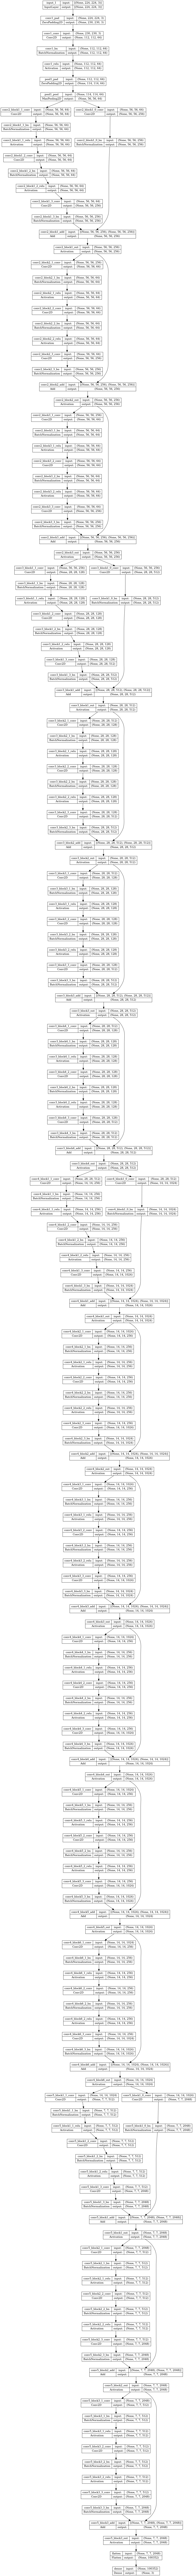

In [13]:
plot_model(model, to_file='cutomsized_resNet50.png', show_shapes=True, show_layer_names=True)

# Freeze all Layers Beside Last Layer

In [14]:
for layer in model.layers[:-1]:
    layer.trainable=False

# Compile Model

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])

# Visualization of Training vs Validation Loss

In [16]:
def plot_loss(model_history,model_name):
    
    plt.figure()
    plt.plot(model_history.epoch, model_history.history['loss'], 'go', label='Training loss')
    plt.plot(model_history.epoch, model_history.history['val_loss'], 'g', label='Validation loss')
    if model_name == model_axial:
        plt.title('Training and Validation Loss of Axial Model')
    elif model_name == model_coronal:
        plt.title('Training and Validation Loss of Coronal Model')
    elif model_name == model_sagittal:
        plt.title('Training and Validation Loss of Sagittal Model')   
    plt.legend()
    plt.show()

# Visualization of Training vs Validation Accuracy

In [17]:
def plot_accuracy(model_history,model_name):
    
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    plt.figure()
    plt.plot(model_history.epoch, acc,'go', label='Training acc')
    plt.plot(model_history.epoch, val_acc, 'g', label='Validation acc')
    if model_name == model_axial:
        plt.title('Training and Validation Accuracy of Axial Model')
    elif model_name == model_coronal:
        plt.title('Training and Validation Accuracy of Coronal Model')
    elif model_name == model_sagittal:
        plt.title('Training and Validation Accuracy of Sagittal Model')   
    plt.legend()
    plt.show()
    acc = np.asarray(acc).mean()
    val_acc = np.asarray(val_acc).mean() 
    print('Mean training accuracy %f ' % acc)
    print('Mean validation accuracy %f' % val_acc)

# Train Model on Each View Separately

In [18]:
model_axial = 'training_axial/cp.ckpt'
model_coronal = 'training_coronal/cp.ckpt'
model_sagittal = 'training_sagittal/cp.ckpt'

In [19]:
def fit_model(training_set, training_labels,validation_set,validation_labels,model_file_name):
  
    history = model.fit(training_set,training_labels,epochs=20,batch_size=24,verbose=True,validation_data=(validation_set,validation_labels)
                     ,callbacks =[EarlyStopping(patience=6, monitor = 'val_loss', mode = 'min'),
                          ModelCheckpoint(model_file_name, monitor='val_acc', save_best_only=True, mode='max', period=1)])
    

    plot_loss(history,model_file_name)
    plot_accuracy(history,model_file_name)
    best_model = load_model(model_file_name)
    return best_model

Epoch 1/20
10/10 [==============================] - 37s 4s/step - loss: 24.8262 - acc: 0.3333 - val_loss: 10.7665 - val_acc: 0.4667
Epoch 2/20
10/10 [==============================] - 17s 2s/step - loss: 6.6576 - acc: 0.5738 - val_loss: 7.4202 - val_acc: 0.4333
Epoch 3/20
10/10 [==============================] - 17s 2s/step - loss: 3.2067 - acc: 0.7215 - val_loss: 6.0245 - val_acc: 0.4333
Epoch 4/20
10/10 [==============================] - 33s 3s/step - loss: 0.8898 - acc: 0.8565 - val_loss: 2.8702 - val_acc: 0.7000
Epoch 5/20
10/10 [==============================] - 33s 4s/step - loss: 0.2016 - acc: 0.9494 - val_loss: 1.7281 - val_acc: 0.7667
Epoch 6/20
10/10 [==============================] - 17s 2s/step - loss: 0.0653 - acc: 0.9747 - val_loss: 2.3743 - val_acc: 0.7000
Epoch 7/20
10/10 [==============================] - 16s 2s/step - loss: 0.0271 - acc: 0.9916 - val_loss: 1.7018 - val_acc: 0.7000
Epoch 8/20
10/10 [==============================] - 17s 2s/step - loss: 0.0229 - acc: 0.

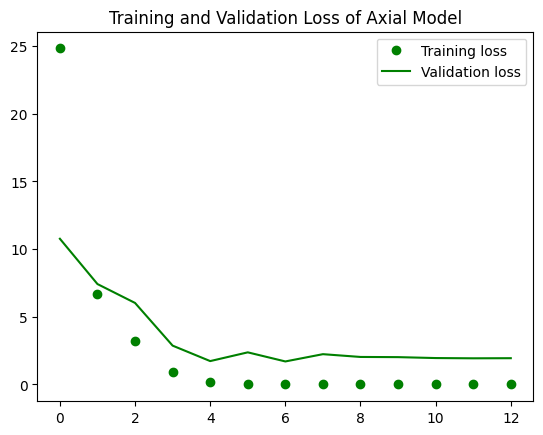

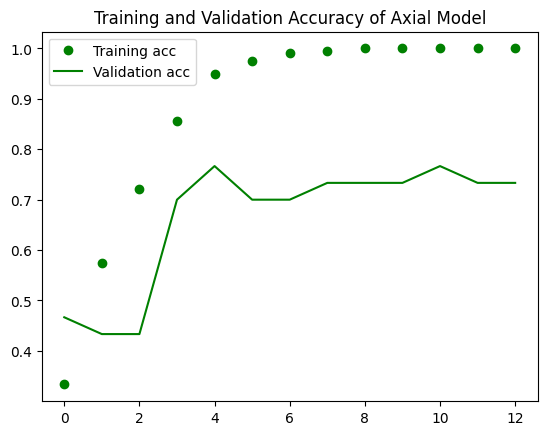

Mean training accuracy 0.876663 
Mean validation accuracy 0.664103
Epoch 1/20
10/10 [==============================] - 33s 3s/step - loss: 9.5183 - acc: 0.4177 - val_loss: 11.5140 - val_acc: 0.4333
Epoch 2/20
10/10 [==============================] - 33s 4s/step - loss: 4.5987 - acc: 0.6624 - val_loss: 5.8136 - val_acc: 0.6333
Epoch 3/20
10/10 [==============================] - 16s 2s/step - loss: 1.6113 - acc: 0.8270 - val_loss: 4.2386 - val_acc: 0.5667
Epoch 4/20
10/10 [==============================] - 33s 4s/step - loss: 0.5897 - acc: 0.9325 - val_loss: 4.4326 - val_acc: 0.6667
Epoch 5/20
10/10 [==============================] - 16s 2s/step - loss: 0.1240 - acc: 0.9747 - val_loss: 3.9470 - val_acc: 0.5667
Epoch 6/20
10/10 [==============================] - 16s 2s/step - loss: 0.0196 - acc: 0.9958 - val_loss: 3.6470 - val_acc: 0.5667
Epoch 7/20
10/10 [==============================] - 16s 2s/step - loss: 0.0205 - acc: 0.9916 - val_loss: 3.3005 - val_acc: 0.6333
Epoch 8/20
10/10 [====

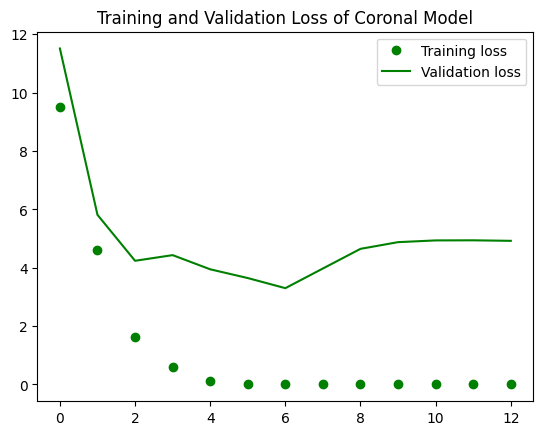

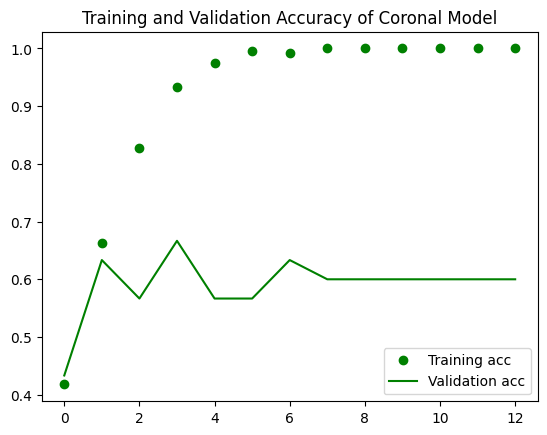

Mean training accuracy 0.907822 
Mean validation accuracy 0.589744
Epoch 1/20
10/10 [==============================] - 33s 4s/step - loss: 14.1049 - acc: 0.4093 - val_loss: 14.0520 - val_acc: 0.3000
Epoch 2/20
10/10 [==============================] - 33s 3s/step - loss: 9.7986 - acc: 0.5359 - val_loss: 12.3876 - val_acc: 0.5333
Epoch 3/20
10/10 [==============================] - 34s 4s/step - loss: 2.9651 - acc: 0.7764 - val_loss: 8.1647 - val_acc: 0.6333
Epoch 4/20
10/10 [==============================] - 33s 4s/step - loss: 1.1570 - acc: 0.9325 - val_loss: 15.0674 - val_acc: 0.6667
Epoch 5/20
10/10 [==============================] - 34s 4s/step - loss: 0.8454 - acc: 0.9156 - val_loss: 3.3402 - val_acc: 0.7000
Epoch 6/20
10/10 [==============================] - 34s 4s/step - loss: 0.3514 - acc: 0.9494 - val_loss: 6.0161 - val_acc: 0.7667
Epoch 7/20
10/10 [==============================] - 16s 2s/step - loss: 0.2759 - acc: 0.9578 - val_loss: 9.5166 - val_acc: 0.7333
Epoch 8/20
10/10 [=

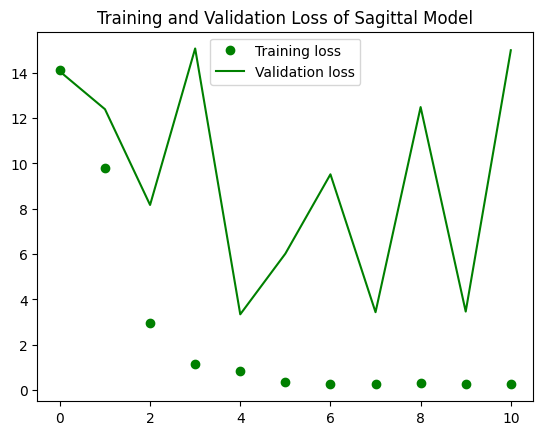

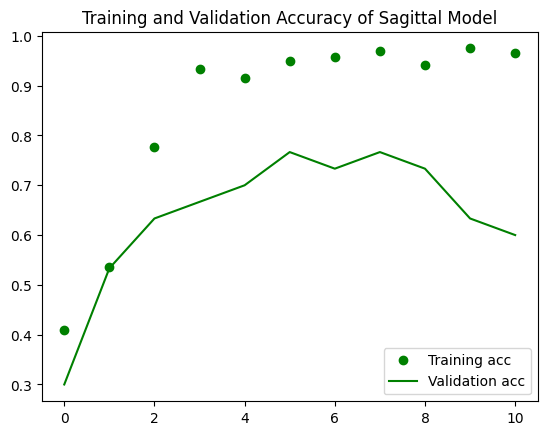

Mean training accuracy 0.848101 
Mean validation accuracy 0.642424


In [20]:
from tensorflow.keras.models import save_model

model_axial=fit_model(train_X_axial,train_Y_axial,valid_X_axial,valid_Y_axial,model_axial)

model_coronal=fit_model(train_X_coronal,train_Y_coronal,valid_X_coronal,valid_Y_coronal,model_coronal)
                   
model_sagittal=fit_model(train_X_sagittal,train_Y_sagittal,valid_X_sagittal,valid_Y_sagittal,model_sagittal)       

# Save Model

In [21]:
model_axial.save('/kaggle/working/model_axial.h5')
model_coronal.save('/kaggle/working/model_coronal.h5')
model_sagittal.save('/kaggle/working/model_sagittal.h5')

# Model Prediction and Check Upload

In [22]:
def get_pred_array(test_data,model_classifier_used):
    
    pred = model_classifier_used.predict(test_data)
    return pred

In [23]:
from sklearn.metrics import accuracy_score

def predict_label(test_data,test_label,image_view,model_classifier_used):
    
    pred = model_classifier_used.predict(test_data)
    actual_label=np.argmax(test_label,axis=1)
    pred_label=np.argmax(pred,axis=1)
    print("The "+ image_view +" accuracy score is",accuracy_score(actual_label, pred_label)*100)
    
    return pred, pred_label,actual_label,accuracy_score(actual_label, pred_label)*100

In [24]:
pred_proba_axial,pred_label_axial,actual_label_axial,axial_acc = predict_label(test_X_axial,test_Y_axial,'axial',model_axial)

pred_proba_coronal,pred_label_coronal,actual_label_coronal,coronal_acc = predict_label(test_X_coronal,test_Y_coronal,'coronal',model_coronal)

pred_proba_sagittal,pred_label_sagittal,actual_label_sagittal,sagittal_acc = predict_label(test_X_sagittal,test_Y_sagittal,'sagittal',model_sagittal)

1/1 [==============================] - 3s 3s/step
The axial accuracy score is 83.33333333333334
1/1 [==============================] - 3s 3s/step
The coronal accuracy score is 63.33333333333333
1/1 [==============================] - 3s 3s/step
The sagittal accuracy score is 66.66666666666666


In [25]:
axial_model_1 = load_model('/kaggle/working/model_axial.h5')
coronal_model_1 = load_model('/kaggle/working/model_coronal.h5')
sagittal_model_1 = load_model('/kaggle/working/model_sagittal.h5')

pred_proba_axial_1,pred_label_axial_1,actual_label_axial_1,axial_1_acc = predict_label(test_X_axial,test_Y_axial,'axial',axial_model_1)

pred_proba_coronal_1,pred_label_coronal_1,actual_label_coronal_1,coronal_1_acc = predict_label(test_X_coronal,test_Y_coronal,'coronal',coronal_model_1)

pred_proba_sagittal_1,pred_label_sagittal_1,actual_label_sagittal_1,sagittal_1_acc = predict_label(test_X_sagittal,test_Y_sagittal,'sagittal',sagittal_model_1)

1/1 [==============================] - 3s 3s/step
The axial accuracy score is 83.33333333333334
1/1 [==============================] - 3s 3s/step
The coronal accuracy score is 63.33333333333333
1/1 [==============================] - 3s 3s/step
The sagittal accuracy score is 66.66666666666666


# Model Confusion Matrix

In [26]:
label_name=["AD","CN","MCI"]

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(image_view,pred_label,actual_label):
    
    ConfusionMatrix = confusion_matrix(actual_label,pred_label)
    sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
    plt.title(image_view + " Confusion Matrix\n")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

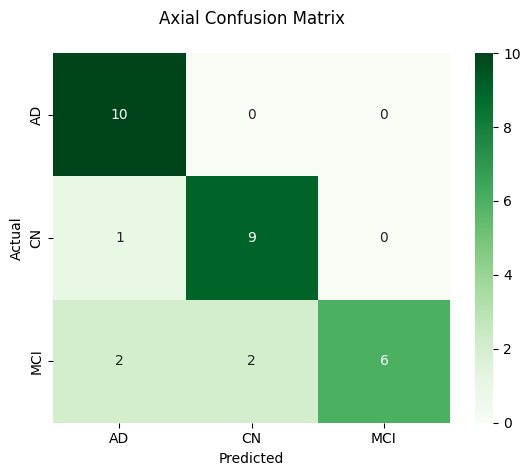

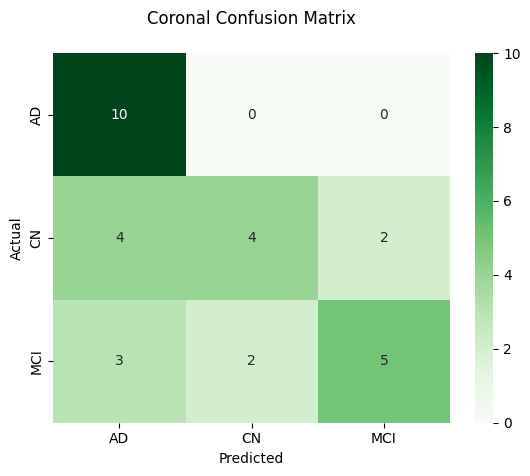

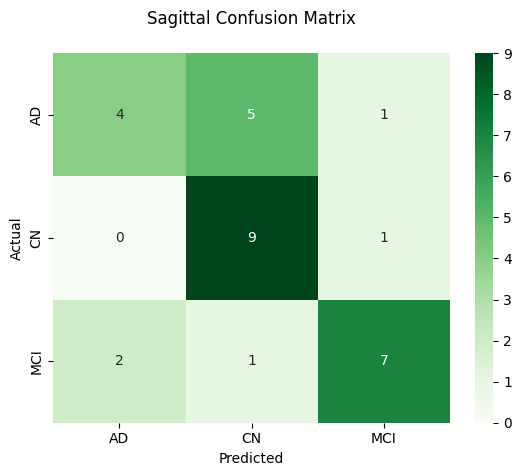

In [28]:
plot_confusion_matrix('Axial',pred_label_axial,actual_label_axial)
plot_confusion_matrix('Coronal',pred_label_coronal,actual_label_coronal)
plot_confusion_matrix('Sagittal',pred_label_sagittal,actual_label_sagittal)

# Model Classification Report

In [29]:
from sklearn.metrics import classification_report

def plot_classification_report(image_view, pred_label,actual_label):
    print("Classification Report of the "+ image_view+" Model\n")
    print(classification_report(actual_label,pred_label, target_names=["AD","CN","MCI"]))

In [30]:
plot_classification_report('Axial',pred_label_axial,actual_label_axial)
plot_classification_report('Coronal',pred_label_coronal,actual_label_coronal)
plot_classification_report('Sagittal',pred_label_sagittal,actual_label_sagittal)

Classification Report of the Axial Model

              precision    recall  f1-score   support

          AD       0.77      1.00      0.87        10
          CN       0.82      0.90      0.86        10
         MCI       1.00      0.60      0.75        10

    accuracy                           0.83        30
   macro avg       0.86      0.83      0.83        30
weighted avg       0.86      0.83      0.83        30

Classification Report of the Coronal Model

              precision    recall  f1-score   support

          AD       0.59      1.00      0.74        10
          CN       0.67      0.40      0.50        10
         MCI       0.71      0.50      0.59        10

    accuracy                           0.63        30
   macro avg       0.66      0.63      0.61        30
weighted avg       0.66      0.63      0.61        30

Classification Report of the Sagittal Model

              precision    recall  f1-score   support

          AD       0.67      0.40      0.50        1

# Model ROC Curve

In [31]:
def helper_function_ROC_Curve(fpr,tpr,roc_auc,label,image_view):
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'g--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title("ROC Curve for " + label+" " +image_view+" Model")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc

def plot_ROC_curve(data_view):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    if data_view == 'axial':
        pred_axial = get_pred_array(test_X_axial,model_axial)
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(test_Y_axial[:, i], pred_axial[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        for i in range(3):
            label = get_label(i)
            helper_function_ROC_Curve(fpr[i], tpr[i],roc_auc[i],label,'Axial')
           
            
    elif data_view == 'coronal':
        pred_coronal = get_pred_array(test_X_coronal,model_coronal)
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(test_Y_coronal[:, i], pred_coronal[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        for i in range(3):
            label = get_label(i)
            helper_function_ROC_Curve(fpr[i], tpr[i],roc_auc[i],label,'Coronal')
    
            
    elif data_view == 'sagittal':
        pred_sagittal = get_pred_array(test_X_sagittal,model_sagittal)
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(test_Y_sagittal[:, i], pred_sagittal[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        for i in range(3):
            label = get_label(i)
            helper_function_ROC_Curve(fpr[i], tpr[i],roc_auc[i],label,'Sagittal')

1/1 [==============================] - 2s 2s/step


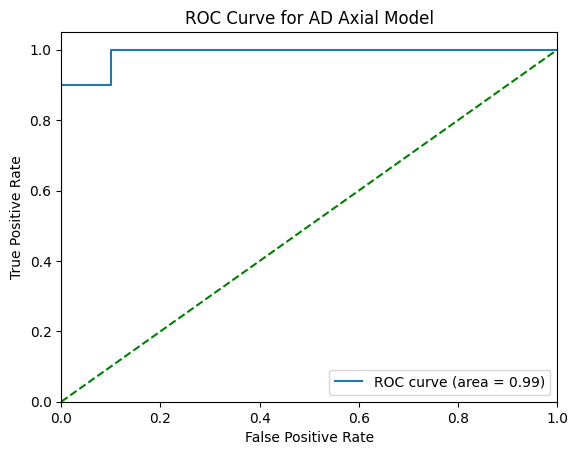

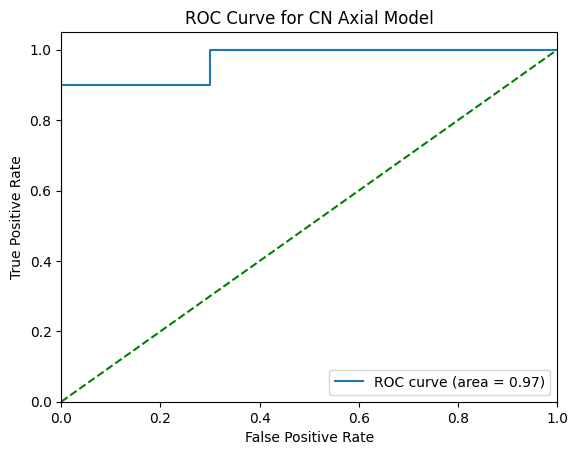

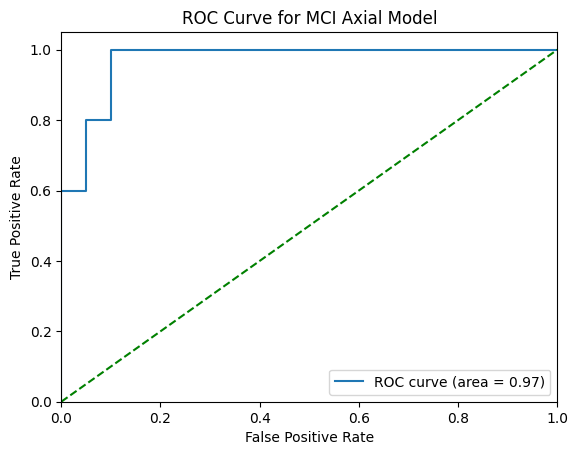

1/1 [==============================] - 2s 2s/step


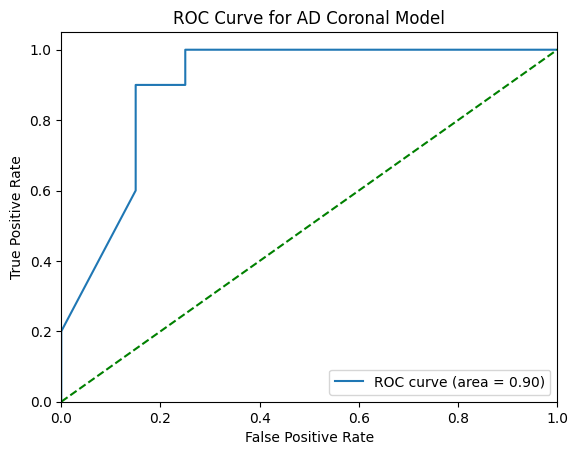

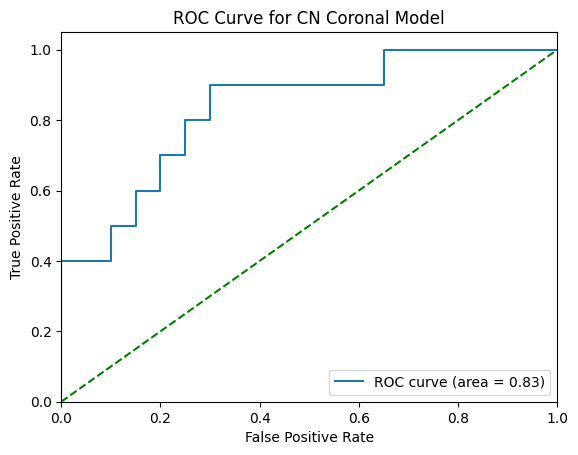

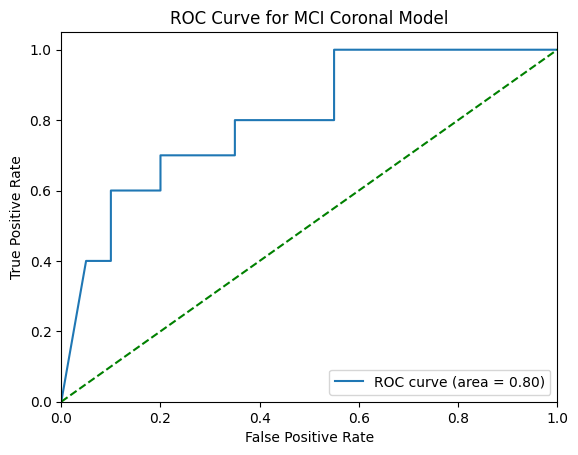

1/1 [==============================] - 2s 2s/step


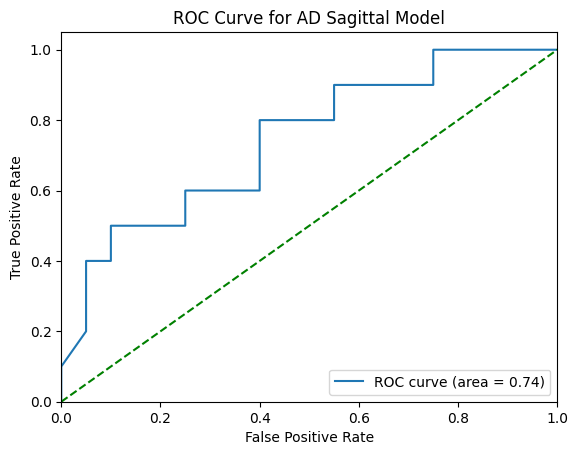

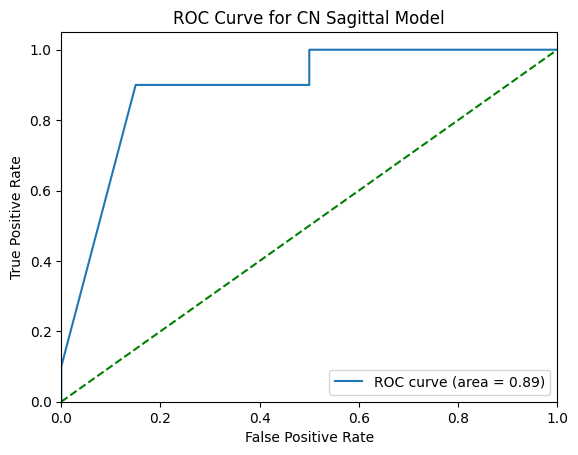

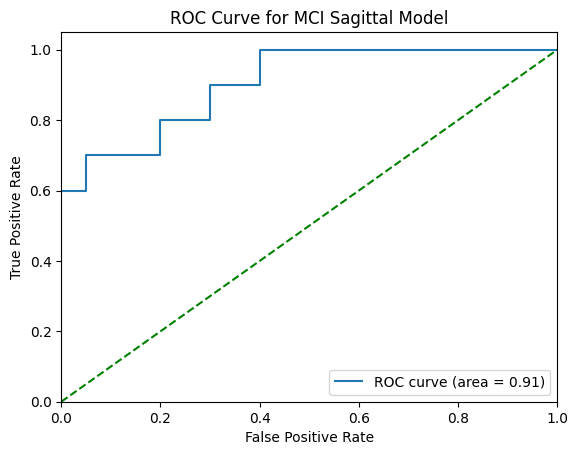

In [33]:
plot_ROC_curve('axial') 
plot_ROC_curve('coronal')
plot_ROC_curve('sagittal')

# Combine Three Models by Voting

In [34]:
sum_acc = axial_acc + coronal_acc + sagittal_acc
axial_weight = axial_acc/sum_acc
coronal_weight = coronal_acc/sum_acc
sagittal_weight = sagittal_acc/sum_acc
print("The axial model weight is: ",axial_weight)
print("The coronal model weight is: ",coronal_weight)
print("The sagittal model weight is: ",sagittal_weight)

The axial model weight is:  0.390625
The coronal model weight is:  0.29687499999999994
The sagittal model weight is:  0.31249999999999994


In [35]:
def get_average_label(iteration_loop,index_label,pred_proba_axial,pred_proba_coronal,pred_proba_sagittal):
    
    proba_axial = pred_proba_axial[iteration_loop][index_label]
    proba_coronal = pred_proba_coronal[iteration_loop][index_label]
    proba_sagittal = pred_proba_sagittal[iteration_loop][index_label]
    
    label_proba = (proba_axial + proba_coronal + proba_sagittal)/3
    label_proba = round(label_proba,2)
    return label_proba

In [36]:
def vote(pred_proba_axial,pred_proba_coronal,pred_proba_sagittal):
    
    predict_voting = []
    for i in range (len(pred_proba_axial)):
        array_label = []
        AD_label_proba = get_average_label(i,0,pred_proba_axial,pred_proba_coronal,pred_proba_sagittal)
        CN_label_proba = get_average_label(i,1,pred_proba_axial,pred_proba_coronal,pred_proba_sagittal)
        MCI_label_proba = get_average_label(i,2,pred_proba_axial,pred_proba_coronal,pred_proba_sagittal)
        array_label.append(AD_label_proba)
        array_label.append(CN_label_proba)
        array_label.append(MCI_label_proba)
    
        max_index,max_item = max_of_three_indices(array_label)
        predict_voting.append(max_index)
        
    return predict_voting,max_item

In [37]:
def vote_with_weight(pred_proba_axial,pred_proba_coronal,pred_proba_sagittal):
    
    predict_voting = []
    for i in range(len(pred_proba_axial)):
        array_combined_probabilities = []
        array_combined_probabilities.append((axial_weight*pred_proba_axial[i][0])+(coronal_weight*pred_proba_coronal[i][0])+(sagittal_weight*pred_proba_sagittal[i][0]))
        array_combined_probabilities.append((axial_weight*pred_proba_axial[i][1])+(coronal_weight*pred_proba_coronal[i][1])+(sagittal_weight*pred_proba_sagittal[i][1]))
        array_combined_probabilities.append((axial_weight*pred_proba_axial[i][2])+(coronal_weight*pred_proba_coronal[i][2])+(sagittal_weight*pred_proba_sagittal[i][2]))
    
        max_index,max_item = max_of_three_indices(array_combined_probabilities)
        predict_voting.append(max_index)
        
    return predict_voting,max_item

In [38]:
predict_voting,max_item = vote(pred_proba_axial,pred_proba_coronal,pred_proba_sagittal)
print("The predicted labels are: ",predict_voting)
print("The accuracy score of the combined models is",accuracy_score(actual_label_axial,np.array(predict_voting))*100)

The predicted labels are:  [0, 2, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 2, 0, 1, 2, 1, 2, 2, 0, 0, 0, 1, 1, 2, 1, 0, 0, 0]
The accuracy score of the combined models is 86.66666666666667


In [39]:
predict_voting_weights,max_item_weights =  vote_with_weight(pred_proba_axial,pred_proba_coronal,pred_proba_sagittal)
print("The predicted labels are: ",predict_voting_weights)
print("The accuracy score of the combined models is",accuracy_score(actual_label_axial,np.array(predict_voting_weights))*100)

The predicted labels are:  [0, 2, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 2, 0, 1, 2, 1, 2, 2, 1, 0, 0, 1, 1, 2, 1, 0, 0, 0]
The accuracy score of the combined models is 90.0


# Confusion Matrix of Combined Models

Text(0.5, 1.0, 'Combined Models Confusion Matrix\n')

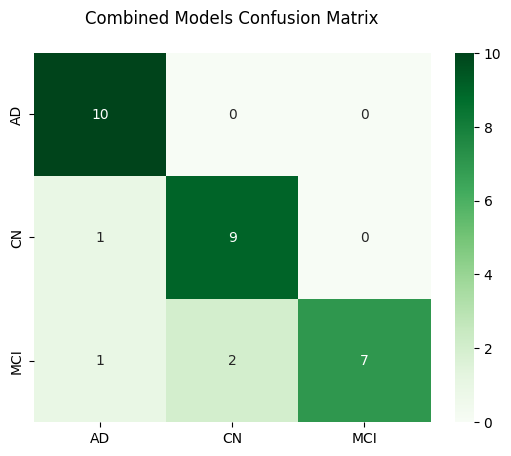

In [40]:
ConfusionMatrix = confusion_matrix(actual_label_axial,np.array(predict_voting))
sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
plt.title("Combined Models Confusion Matrix\n")

Text(0.5, 1.0, 'Combined Models Confusion Matrix\n')

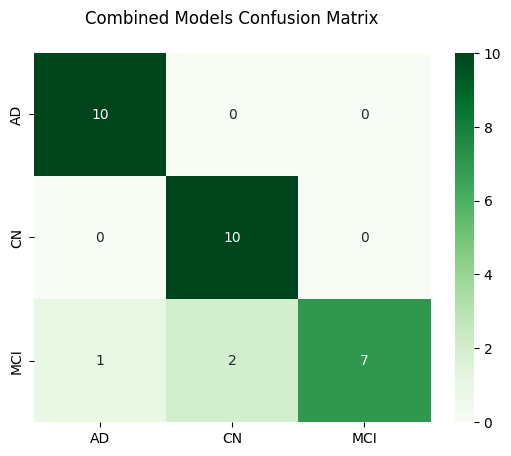

In [41]:
ConfusionMatrix = confusion_matrix(actual_label_axial,np.array(predict_voting_weights))
sns.heatmap(ConfusionMatrix, annot=True, fmt="d", cmap="Greens", xticklabels=label_name, yticklabels=label_name)
plt.title("Combined Models Confusion Matrix\n")

# Classification Report of Combined Models

In [42]:
print("Classification Report of the Combined Models\n")
print(classification_report(actual_label_axial,np.array(predict_voting), target_names=["AD","CN","MCI"]))

Classification Report of the Combined Models

              precision    recall  f1-score   support

          AD       0.83      1.00      0.91        10
          CN       0.82      0.90      0.86        10
         MCI       1.00      0.70      0.82        10

    accuracy                           0.87        30
   macro avg       0.88      0.87      0.86        30
weighted avg       0.88      0.87      0.86        30



In [43]:
print("Classification Report of the Combined Models\n")
print(classification_report(actual_label_axial,np.array(predict_voting_weights), target_names=["AD","CN","MCI"]))

Classification Report of the Combined Models

              precision    recall  f1-score   support

          AD       0.91      1.00      0.95        10
          CN       0.83      1.00      0.91        10
         MCI       1.00      0.70      0.82        10

    accuracy                           0.90        30
   macro avg       0.91      0.90      0.90        30
weighted avg       0.91      0.90      0.90        30



# Combined Models Probabilities Testing

In [44]:
def test_case_one_image(view,image_view,model_used):
    
    plt.imshow(view, cmap='gray')
    plt.show()
    plt.axis('off')
    
    view = np.expand_dims(view, axis = 0)
    result= model_used.predict(view)
    result_label=np.argmax(result,axis=1)
    probability= round((maxProbability(result)*100),2)
    print(probability, '% chances are there that the image is:',get_label(result_label[0]),'as predicted by '+image_view + ' model')     
            
    return result,result_label

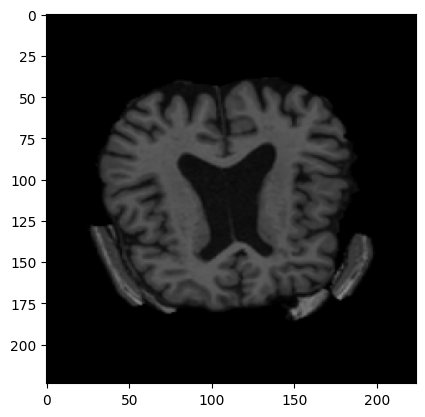

1/1 [==============================] - 0s 102ms/step
100.0 % chances are there that the image is: CN as predicted by axial model


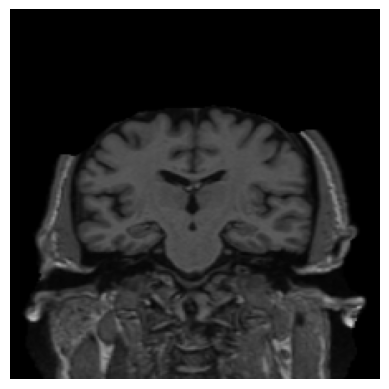

1/1 [==============================] - 0s 114ms/step
99.94 % chances are there that the image is: MCI as predicted by coronal model


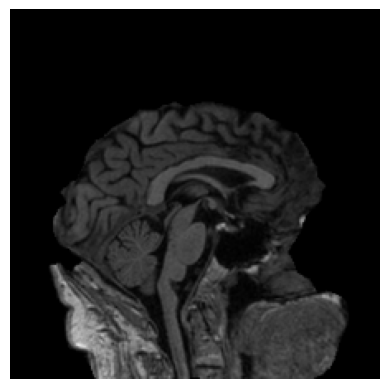

1/1 [==============================] - 0s 100ms/step
100.0 % chances are there that the image is: CN as predicted by sagittal model
The actual label is CN
0.67 % chances are there that the image is: CN as predicted by all models combined


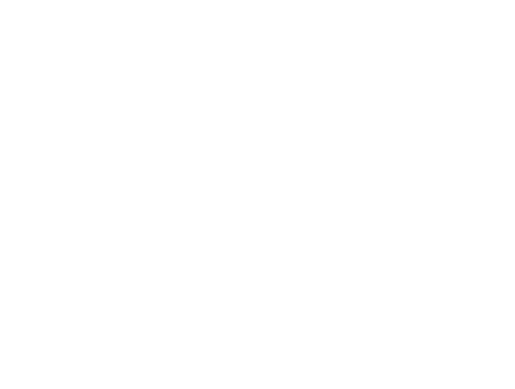

In [45]:
#TEST CASE
proba_axial,result_axial_label = test_case_one_image(test_X_axial[8],'axial',model_axial)
proba_coronal,result_coronal_label = test_case_one_image(test_X_coronal[8],'coronal',model_axial)
proba_sagittal,result_sagittal_label = test_case_one_image(test_X_sagittal[8],'sagittal',model_sagittal)

predict_voting,max_item = vote(proba_axial,proba_coronal,proba_sagittal)

print('The actual label is',get_label(np.argmax(test_Y_axial,axis=1)[8]))
print(max_item, '% chances are there that the image is:',get_label(predict_voting[0]),'as predicted by all models combined')

# GradCam

In [46]:
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm

In [47]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
   
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [48]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
  
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))

Axial View GradCam


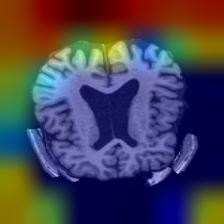

Coronal View GradCam


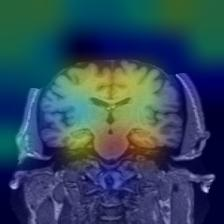

Sagittal View GradCam


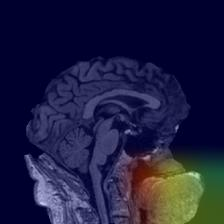

In [49]:
last_layer = "conv5_block3_3_conv"
image_axial = np.expand_dims(test_X_axial[8], axis = 0)
image_coronal = np.expand_dims(test_X_coronal[8], axis = 0)
image_sagittal = np.expand_dims(test_X_sagittal[8], axis = 0)

print("Axial View GradCam")
heatmap = make_gradcam_heatmap(image_axial,model_axial,last_layer)
save_and_display_gradcam(test_X_axial[8], heatmap)

print("Coronal View GradCam")
heatmap = make_gradcam_heatmap(image_coronal,model_coronal,last_layer)
save_and_display_gradcam(test_X_coronal[8], heatmap)

print("Sagittal View GradCam")
heatmap = make_gradcam_heatmap(image_sagittal,model_sagittal,last_layer)
save_and_display_gradcam(test_X_sagittal[8], heatmap)